In [3]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np
import copy as cp
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
train_input = pd.read_csv('./data/[new] yancheng_train_20171226.csv')

C:\Users\jinda\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train_data = cp.copy(train_input)

<font color=orange size=6 face="黑体">处理if_charging的数据 </font>

In [6]:
if_charging_map = {'L': 1, 'T': 0}
train_data['if_charging'] = train_data['if_charging'].apply(lambda x: if_charging_map[x])

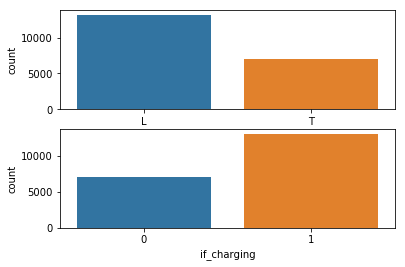

In [7]:
#观察变化
plt.subplot(2,1,1)
sns.countplot(train_input.if_charging)
plt.subplot(2,1,2)
sns.countplot(train_data.if_charging)

<font color=orange size=6 face="黑体">处理price_level的数据,将其分类，分成n类别 </font>

In [8]:
price_map = {'5WL':0, '5-8W':1, '8-10W':2, '10-15W':3, '15-20W':4, '20-25W':5, '25-35W':6, '35-50W':7, '50-75W':8}
train_data['price_level'] = train_input['price_level'].apply(lambda x: price_map[x])

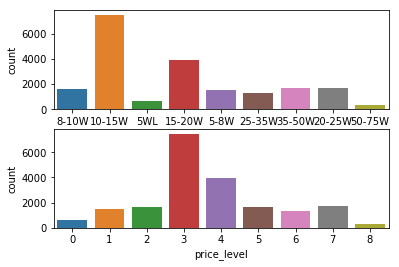

In [9]:
#观察变化
plt.subplot(2,1,1)
sns.countplot(train_input.price_level)
plt.subplot(2,1,2)
sns.countplot(train_data.price_level)

<font color=orange size=6 face="黑体">处理gear_box </font>

In [10]:
gearbox_map = {'MT':0, 'DCT':1, 'AT':2, 'CVT':3, 'AMT':4, 'AT;DCT':5, 'MT;AT':6}
train_data['gearbox_type'] = train_input['gearbox_type'].apply(lambda x: gearbox_map[x])

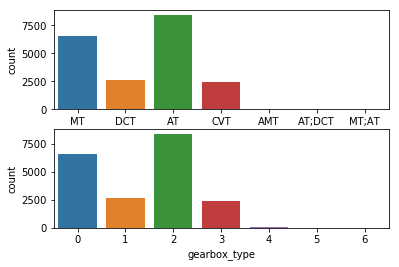

In [11]:
#观察变化
plt.subplot(2,1,1)
sns.countplot(train_input.gearbox_type)
plt.subplot(2,1,2)
sns.countplot(train_data.gearbox_type)

<font color=orange size=6 face="黑体">处理丢失的price</font>

In [12]:
train_data.loc[train_data['price'] == '-', 'price'] = 999999

<font color=orange size=6 face="黑体">处理乱码的乘车人数量e</font>

In [13]:
rated_passenger_map = {'5':0, '7-8':1, '7':2, '6-7':3, '6-8':4, '4':5, '4-5':6, '5-7':7, '5-8':8, '9':9}
train_data['rated_passenger'] = train_input['rated_passenger'].apply(lambda x: rated_passenger_map[x])

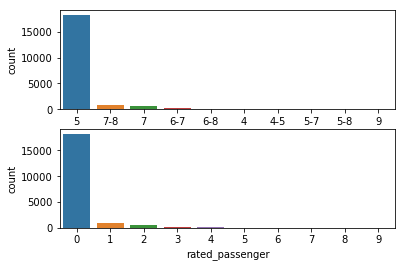

In [14]:
#观察变化
plt.subplot(2,1,1)
sns.countplot(train_input.rated_passenger)
plt.subplot(2,1,2)
sns.countplot(train_data.rated_passenger)

In [13]:
train_data[:5]

,sale_date,class_id,sale_quantity,brand_id,compartment,type_id,level_id,department_id,TR,gearbox_type,...,engine_torque,car_length,car_width,car_height,total_quality,equipment_quality,rated_passenger,wheelbase,front_track,rear_track
0,201609,289403,94,12,2,1,1,1,6,0,...,170,4440,1833,1545,1695,1320,0,2700,1556,1562
1,201609,745137,435,637,3,2,1,2,6,1,...,159,4534,1823,1483,1711,1336,0,2648,1553,1544
2,201609,714860,180,831,3,2,2,3,6,2,...,176,4720,1815,1465,1860,1459,0,2770,1579,1589
3,201609,175962,40,750,3,2,1,4,6,2,...,155,4475,1706,1469,1625,1145,0,2603,1460,1500
4,201609,270690,19,98,2,3,3,1,5,0,...,146.5,4415,1685,1850,1825,1236,0,2720,1420,1440


In [14]:
y_train = train_data.sale_quantity
x_train = cp.copy(train_data).drop('sale_quantity', axis=1)

In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20157 entries, 0 to 20156
Data columns (total 31 columns):
sale_date                20157 non-null int64
class_id                 20157 non-null int64
brand_id                 20157 non-null int64
compartment              20157 non-null int64
type_id                  20157 non-null int64
level_id                 20157 non-null object
department_id            20157 non-null int64
TR                       20157 non-null object
gearbox_type             20157 non-null int64
displacement             20157 non-null float64
if_charging              20157 non-null int64
price_level              20157 non-null int64
price                    20157 non-null object
driven_type_id           20157 non-null int64
fuel_type_id             20157 non-null object
newenergy_type_id        20157 non-null int64
emission_standards_id    20157 non-null int64
if_MPV_id                20157 non-null int64
if_luxurious_id          20157 non-null int64
power      

In [16]:
for f in x_train.columns: 
    if x_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(x_train[f].values)) 
        x_train[f] = lbl.transform(list(x_train[f].values))

x_train.fillna((-999), inplace=True) 

x_train=np.array(x_train) 
x_train = x_train.astype(float) 

In [17]:
x_train = pd.DataFrame(x_train)
y_train = y_train.astype(float)
x_train

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,201609.0,289403.0,12.0,2.0,1.0,1.0,1.0,5.0,0.0,1.8,...,36.0,4440.0,1833.0,1545.0,1695.0,1320.0,0.0,2700.0,1556.0,1562.0
1,201609.0,745137.0,637.0,3.0,2.0,1.0,2.0,5.0,1.0,1.6,...,30.0,4534.0,1823.0,1483.0,1711.0,1336.0,0.0,2648.0,1553.0,1544.0
2,201609.0,714860.0,831.0,3.0,2.0,2.0,3.0,5.0,2.0,1.8,...,42.0,4720.0,1815.0,1465.0,1860.0,1459.0,0.0,2770.0,1579.0,1589.0
3,201609.0,175962.0,750.0,3.0,2.0,1.0,4.0,5.0,2.0,1.6,...,26.0,4475.0,1706.0,1469.0,1625.0,1145.0,0.0,2603.0,1460.0,1500.0
4,201609.0,270690.0,98.0,2.0,3.0,3.0,1.0,3.0,0.0,1.5,...,19.0,4415.0,1685.0,1850.0,1825.0,1236.0,0.0,2720.0,1420.0,1440.0
5,201609.0,290854.0,537.0,2.0,1.0,1.0,5.0,0.0,3.0,2.0,...,51.0,4585.0,1820.0,1685.0,2010.0,1540.0,0.0,2620.0,1580.0,1580.0
6,201609.0,692703.0,807.0,2.0,1.0,1.0,1.0,3.0,0.0,1.3,...,60.0,4510.0,1852.0,1677.0,1900.0,1450.0,0.0,2650.0,1575.0,1570.0
7,201609.0,978089.0,12.0,2.0,2.0,1.0,1.0,3.0,0.0,1.5,...,13.0,4425.0,1789.0,1470.0,1611.0,1236.0,0.0,2650.0,1502.0,1492.0
8,201609.0,219195.0,638.0,2.0,1.0,3.0,1.0,5.0,2.0,1.5,...,63.0,4335.0,1814.0,1695.0,1895.0,1520.0,0.0,2560.0,1525.0,1520.0
9,201609.0,851857.0,75.0,2.0,1.0,2.0,2.0,7.0,2.0,2.0,...,106.0,4812.0,1903.0,1680.0,2375.0,1885.0,0.0,2857.0,1645.0,1645.0


<font color=orange size=6>随机分布得到验证集核训练集</font>

In [1]:
seed = 7
test_size = 0.33
x_train_part, x_validate, y_train_part, y_validate= train_test_split(x_train, y_train, test_size=test_size,
    random_state=seed)

NameError: name 'train_test_split' is not defined

<font color=orange size=6>以下开始XGBOOST调试过程</font>

In [2]:
dtrain = xgb.DMatrix(x_train_part, y_train_part)
dvalid = xgb.DMatrix(x_validate, y_validate)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]  
num_trees=1000
params = {"objective": "reg:linear",  
              "eta": 0.1,  
              "max_depth": 10,  
              "subsample": 0.7,  
              "colsample_bytree": 0.7,  
              "silent": 1,

              }  

NameError: name 'xgb' is not defined

<font color=blue size=5>将一部分作为验证集，一部分作为训练集</font>

In [72]:
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, verbose_eval=True)  


[0]	train-rmse:239.648	eval-rmse:257.144
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:224.55	eval-rmse:243.314
[2]	train-rmse:210.69	eval-rmse:230.678
[3]	train-rmse:197.652	eval-rmse:217.774
[4]	train-rmse:185.609	eval-rmse:206.388
[5]	train-rmse:175.434	eval-rmse:196.894
[6]	train-rmse:165.859	eval-rmse:188.595
[7]	train-rmse:157.242	eval-rmse:180.79
[8]	train-rmse:150.07	eval-rmse:173.722
[9]	train-rmse:143.086	eval-rmse:167.978
[10]	train-rmse:136.409	eval-rmse:162.785
[11]	train-rmse:130.696	eval-rmse:158.779
[12]	train-rmse:124.731	eval-rmse:153.546
[13]	train-rmse:119.579	eval-rmse:149.338
[14]	train-rmse:115.083	eval-rmse:145.663
[15]	train-rmse:110.66	eval-rmse:142.756
[16]	train-rmse:107.656	eval-rmse:140.705
[17]	train-rmse:104.559	eval-rmse:138.357
[18]	train-rmse:101.847	eval-rmse:136.995
[19]	train-rmse:98.9221	eval-rmse:135.362
[20]	train-rmse:96.5502	eval-rms

In [73]:
gbm.save_model('./model_201801271713')

<font color=orange size=6>对于预测集来进行处理</font>

In [153]:
x_test = pd.read_csv("./data/yancheng_testA_20171225.csv").drop('predict_quantity',1)

In [154]:
x_test = np.array(x_test)
zero = [np.array([0]*29)]*len(x_test)
x_test = pd.DataFrame(np.concatenate((x_test, zero), axis=1))

In [155]:
x_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,201711,103507,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,201711,124140,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,201711,125403,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,201711,136916,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,201711,169673,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
for f in range(len(x_test)):
    for ff in range(len(x_train)):
        if x_test[1][f] == x_train[1][ff]:
            x_test.iloc[f] = x_train.iloc[ff]
            break
            

In [160]:
x_test_data = xgb.DMatrix(x_test)
y_pred = gbm.predict(data=x_test_data)

In [161]:
y_pred

array([  2.73088479e+00,   1.45453720e+02,   5.92513962e+01,
         1.59288208e+02,   8.33795013e+01,   6.33750381e+01,
         3.01604366e+01,   1.93883606e+02,   1.86655426e+02,
         2.62119541e+01,   9.64596100e+01,   1.28915512e+02,
         1.61368378e+02,   1.00190971e+02,   5.41310005e+01,
         4.23715935e+01,   2.55310699e+02,   2.54182053e+01,
         1.56406616e+02,   6.72966309e+01,   4.19825592e+01,
         2.89584999e+01,   3.22561874e+01,   3.47043228e+01,
         6.15371895e+01,   9.39080963e+01,   2.36872845e+01,
         3.66058998e+01,   3.76842766e+01,   2.79206200e+01,
         2.30882359e+01,   3.55346870e+01,   1.03507927e+02,
         3.19315094e+02,   3.09862183e+02,   1.72550564e+01,
         1.77393463e+02,   6.75557190e+02,   1.41067413e+02,
         6.90399399e+01,   8.93822250e+01,   3.07320435e+02,
         2.28337250e+02,   2.94584560e+01,   2.93740509e+02,
         3.14576225e+01,   3.48954865e+02,   8.51763611e+01,
        -1.15273535e-01,

In [163]:
y_pred[y_pred<0] = 0

In [191]:
y_pred = np.array(y_pred, dtype=np.int32)

In [192]:
pred_final = pd.read_csv("./data/yancheng_testA_20171225.csv")

In [193]:
for x in range(len(pred_final)):
    pred_final['predict_quantity'][x] = y_pred[x]


C:\Users\jinda\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [194]:
pd.DataFrame.to_csv(pred_final, "./results/final_answer.csv",index=False)

In [195]:
pred_final

,predict_date,class_id,predict_quantity
0,201711,103507,2.0
1,201711,124140,145.0
2,201711,125403,59.0
3,201711,136916,159.0
4,201711,169673,83.0
5,201711,175962,63.0
6,201711,178529,30.0
7,201711,186250,193.0
8,201711,194201,186.0
9,201711,194450,26.0
